## Pytorch Lightning MLP Demo

We demonstrate the Multilayer Preceptron (MLP). Nearly a duplicate to our MLP demo [here](https://github.com/izzajalandoni/Deep-Learning-Helper/blob/main/BuildingBlocks/mlp_demo.ipynb), except we will be utilizing Pytorch Lightning for training.

In [1]:
import warnings
warnings.filterwarnings('ignore')

### Preparing our Dataset

We use the same cifar10 dataset we used in our Hugging Face datasets demo.

In [2]:
import datasets

trainset = datasets.load_dataset('cifar10', split='train')
testset = datasets.load_dataset('cifar10', split='test')

Reusing dataset cifar10 (/home/izza/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)
Reusing dataset cifar10 (/home/izza/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4)


Preprocess our input before passing them to our dataloader.

**Note:** Unlike the previous demo, we do not remove `label` because we need this as ground truth during training. We simply transform our PIL image to tensor.

In [3]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor()
])

def transform_input(data):
    data['img'] = [transform(image.convert('RGB')) for image in data['img']]
    return data

In [4]:
trainset.set_transform(transform=transform_input)
testset.set_transform(transform=transform_input)

In [5]:
trainset[0]

{'img': tensor([[[0.6980, 0.6980, 0.6980,  ..., 0.6667, 0.6588, 0.6471],
          [0.7059, 0.7020, 0.7059,  ..., 0.6784, 0.6706, 0.6588],
          [0.6941, 0.6941, 0.6980,  ..., 0.6706, 0.6627, 0.6549],
          ...,
          [0.4392, 0.4431, 0.4471,  ..., 0.3922, 0.3843, 0.3961],
          [0.4392, 0.4392, 0.4431,  ..., 0.4000, 0.4000, 0.4000],
          [0.4039, 0.3922, 0.4039,  ..., 0.3608, 0.3647, 0.3569]],
 
         [[0.6902, 0.6902, 0.6902,  ..., 0.6588, 0.6510, 0.6392],
          [0.6980, 0.6941, 0.6980,  ..., 0.6706, 0.6627, 0.6510],
          [0.6863, 0.6863, 0.6902,  ..., 0.6627, 0.6549, 0.6471],
          ...,
          [0.4196, 0.4275, 0.4314,  ..., 0.3804, 0.3686, 0.3725],
          [0.4000, 0.4039, 0.4039,  ..., 0.3725, 0.3647, 0.3608],
          [0.3765, 0.3647, 0.3725,  ..., 0.3294, 0.3373, 0.3294]],
 
         [[0.7412, 0.7412, 0.7412,  ..., 0.7059, 0.6941, 0.6824],
          [0.7490, 0.7451, 0.7490,  ..., 0.7137, 0.7059, 0.6941],
          [0.7373, 0.7373, 0.7412

Pass our data to torch DataLoader() function.

In [6]:
import torch

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4)
testloader = torch.utils.data.DataLoader(testset, batch_size=4)

In [7]:
batch = next(iter(testloader))
print(batch['img'].shape)

torch.Size([4, 3, 32, 32])


### Utility Functions

Display function, accuracy calculation that we might use later.

In [8]:
import matplotlib.pyplot as plt

labels = {0:"airplane", 1:"automobile", 2:"bird", 3:"cat", 4:"deer",
          5:"dog", 6:"frog", 7:"horse", 8:"ship", 9:"truck"}

def display_outputs(x, y_p, y):
    num_outputs = x.shape[0]
    y_p = torch.argmax(y_p, dim=1)
    
    for i in range(num_outputs):
        image = x[i].permute((1,2,0))
        plt.imshow(image)
        plt.show()
        print("Ground Truth: {}[{}], Predicted: {}[{}]".format(
            labels[y[i].item()], y[i], labels[y_p[i].item()], y_p[i]))
        
def accuracy(y_p, y):
    y_p = torch.argmax(y_p, dim=1) # We get top class
    acc = y_p.eq(y).sum()          # Compare it with ground truth
    acc = acc/y.shape[0]           # Get acc for the batch
    return acc

### Preparing our Model

We create our MLP model. We will use Pytorch Lightning for this.

Learn more about NN building blocks [here](https://pytorch.org/docs/stable/nn.html). Notes on pytorch lightning callbacks [here](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.callbacks.Callback.html).

In [9]:
import pytorch_lightning as pl
import torch.nn as nn
import torchmetrics as tm

class MLP(pl.LightningModule):
    def __init__(self, input_dim, num_class):
        super().__init__()
        self.input_dim = input_dim
        self.num_class = num_class
        
        self.fc1 = nn.Linear(self.input_dim, 128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64, self.num_class)
        self.relu = nn.ReLU()
        self.criterion = nn.CrossEntropyLoss()
        
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)
    
    def display(self, x, y_p, y):
        num_outputs = x.shape[0]
        y_p = torch.argmax(y_p, dim=1)

        for i in range(num_outputs):
            image = x[i].permute((1,2,0))
            plt.imshow(image)
            plt.show()
            print("Ground Truth: {}[{}], Predicted: {}[{}]".format(
                labels[y[i].item()], y[i], labels[y_p[i].item()], y_p[i]))
    
    def training_step(self, batch, batch_idx):
        x,y = batch['img'], batch['label']
        y_p = self.forward(x)
        loss = self.criterion(y_p, y)
        
        # Since this is per batch, we can sum correct predictions first
        acc = torch.argmax(y_p, dim=1).eq(y).sum()
        acc = acc/y.shape[0]
        
        return {"loss": loss, "acc": acc}
    
    def training_epoch_end(self, outputs):
        epoch_loss = torch.stack([out['loss'] for out in outputs]).mean()
        epoch_acc = torch.stack([out['acc'] for out in outputs]).mean()
        
        print("Epoch {}, Loss: {}, Accuracy: {}".format(self.current_epoch, epoch_loss, epoch_acc))
    
    def test_step(self, batch, batch_idx):
        x,y = batch['img'], batch['label']
        y_p = self.forward(x)
        
        if batch_idx == 0:
            self.display(x, y_p, y)
        
        # Calculate accuracy
        acc = torch.argmax(y_p, dim=1).eq(y).sum()
        acc = acc/y.shape[0]
        return {"acc": acc}
    
    def test_epoch_end(self, outputs):
        test_acc = torch.stack([out['acc'] for out in outputs]).mean()
        print("Test Accuracy: {}".format(test_acc))
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

### Main Program

We need to get some details about our data that we will use for our model configs.

In [10]:
import numpy as np

b,c,h,w = batch['img'].shape
input_dim = c*h*w
num_class = len(np.unique(testset[:]['label']))

print("input size: {}, num_class: {}".format(input_dim, num_class))

input size: 3072, num_class: 10


With pytorch lightning, our main code becomes cleaner.

In [11]:
num_epochs = 5

model = MLP(input_dim, num_class)
trainer = pl.Trainer(devices="auto", accelerator="auto",
                    max_epochs=num_epochs)
trainer.fit(model, trainloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type             | Params
-----------------------------------------------
0 | fc1       | Linear           | 393 K 
1 | fc2       | Linear           | 8.3 K 
2 | fc3       | Linear           | 650   
3 | relu      | ReLU             | 0     
4 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
402 K     Trainable params
0         Non-trainable params
402 K     Total params
1.609     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Epoch 0, Loss: 1.8849409818649292, Accuracy: 0.3097600042819977
Epoch 1, Loss: 1.7790148258209229, Accuracy: 0.35468000173568726
Epoch 2, Loss: 1.7473351955413818, Accuracy: 0.36381998658180237
Epoch 3, Loss: 1.7267974615097046, Accuracy: 0.37327998876571655
Epoch 4, Loss: 1.712096095085144, Accuracy: 0.3776000142097473


Testing: 0it [00:00, ?it/s]

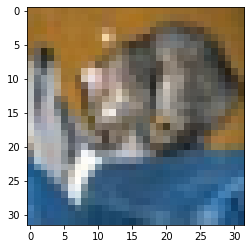

Ground Truth: cat[3], Predicted: cat[3]


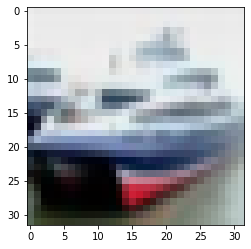

Ground Truth: ship[8], Predicted: ship[8]


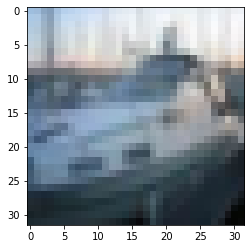

Ground Truth: ship[8], Predicted: ship[8]


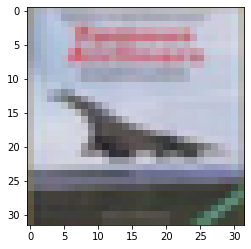

Ground Truth: airplane[0], Predicted: ship[8]
Test Accuracy: 0.39629998803138733


[{}]

In [12]:
trainer.test(model, testloader)

This is for demo purposes. You may try to improve accuracy by experimenting on different parameters, or increasing training epochs.

For more info about pytorch lightning, please visit [this link](https://www.pytorchlightning.ai/)